# Virtual dataset reader and plotter
### (NASA CMR Shortname: SWOT_L2_LR_SSH_Basic_2.0)

#### *Author: Ed Armstrong, PO.DAAC*

*Reference herein to any specific commercial product, process, or service by trade name, trademark, manufacturer, or otherwise, does not constitute or imply its endorsement by the United States Government or the Jet Propulsion Laboratory, California Institute of Technology.*

In [11]:
# Filesystem management 
import fsspec
import earthaccess

# Data handling
import xarray as xr

# Numpy
import numpy as np

# Other mapping
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [12]:
 pip list | grep -E  -e  '(^xarray|numpy|earthaccess|fsspec)'

if: Expression Syntax.
then: Command not found.
earthaccess               0.14.0
fsspec                    2024.10.0
numpy                     2.2.4
xarray                    2025.1.1
Note: you may need to restart the kernel to use updated packages.


## 1. Earthdata Cloud auth


In [13]:
# Get Earthdata creds
earthaccess.login()

## 2. Generate and open reference files 

The reference can be saved to file and used to open the corresponding CCMP data file with Xarray:

In [14]:
# Open data using the reference file, using a small wrapper function around xarray's open_dataset. 
# This will shorten code blocks in other sections. 
def get_vds_mapper(vds_link, in_cloud_region=False):
    """
    Produces a virtudal dataset mapper that can be passed to xarray. 
    
    * vds_link: str, link to the mapper
    * in_cloud_region: bool, True if in cloud in the same region as the data, 
        False otherwise.
    """

    if in_cloud_region:
        fs_data = earthaccess.get_s3_filesystem(daac="PODAAC")
        remote_protocol = "s3"
    else:
        fs_data = earthaccess.get_fsspec_https_session()
        # We set this header to identify usage of the VDS. This helps us support continued development. 
        fs_data.client_kwargs['headers']['User-Agent'] = "virtual-dataset-consumer"
        remote_protocol = "https"
    
    storage_opts = {"fo": vds_link, "remote_protocol": remote_protocol, "remote_options": fs_data.storage_options}
    fs_ref = fsspec.filesystem('reference', **storage_opts)
    return fs_ref.get_mapper('')

In [15]:
%%time

# Path to VDS
vds_link = '/Users/earmstro/Downloads/SWOT_L2_LR_SSH_Basic_2.0_virtual_https.json'#vds_link = 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-public/virtual_collections/OSTIA-UKMO-L4-GLOB-REP-v2.0/OSTIA-UKMO-L4-GLOB-REP-v2.0_virtual_s3.json'

# Lets open the JSON VDS
vds_mapper = get_vds_mapper(vds_link, in_cloud_region=False)

## No modification needed!
data = xr.open_dataset(
    vds_mapper, engine="zarr", chunks={},
    backend_kwargs={"consolidated": False}
)
data


CPU times: user 1.83 s, sys: 261 ms, total: 2.09 s
Wall time: 5.45 s


<xarray.Dataset> Size: 2TB
Dimensions:                                (orbit: 18374, num_lines: 9866,
                                            num_pixels: 69, num_sides: 2)
Coordinates:
    latitude                               (orbit, num_lines, num_pixels) float64 100GB dask.array<chunksize=(1, 9866, 69), meta=np.ndarray>
    longitude                              (orbit, num_lines, num_pixels) float64 100GB dask.array<chunksize=(1, 9866, 69), meta=np.ndarray>
  * orbit                                  (orbit) datetime64[ns] 147kB 2023-...
Dimensions without coordinates: num_lines, num_pixels, num_sides
Data variables: (12/24)
    ancillary_surface_classification_flag  (orbit, num_lines, num_pixels) float32 50GB dask.array<chunksize=(1, 9866, 69), meta=np.ndarray>
    distance_to_coast                      (orbit, num_lines, num_pixels) float64 100GB dask.array<chunksize=(1, 9866, 69), meta=np.ndarray>
    dynamic_ice_flag                       (orbit, num_lines, num_pixels) float32 50GB dask.array<chunksize=(1, 9866, 69), meta=np.ndarray>
    geoid                                  (orbit, num_lines, num_pixels) float64 100GB dask.array<chunksize=(1, 9866, 69), meta=np.ndarray>
    heading_to_coast                       (orbit, num_lines, num_pixels) float64 100GB dask.array<chunksize=(1, 9866, 69), meta=np.ndarray>
    height_cor_xover                       (orbit, num_lines, num_pixels) float64 100GB dask.array<chunksize=(1, 9866, 69), meta=np.ndarray>
    ...                                     ...
    ssha_karin                             (orbit, num_lines, num_pixels) float64 100GB dask.array<chunksize=(1, 9866, 69), meta=np.ndarray>
    ssha_karin_2                           (orbit, num_lines, num_pixels) float64 100GB dask.array<chunksize=(1, 9866, 69), meta=np.ndarray>
    ssha_karin_2_qual                      (orbit, num_lines, num_pixels) float64 100GB dask.array<chunksize=(1, 9866, 69), meta=np.ndarray>
    ssha_karin_qual                        (orbit, num_lines, num_pixels) float64 100GB dask.array<chunksize=(1, 9866, 69), meta=np.ndarray>
    time                                   (orbit, num_lines) datetime64[ns] 1GB dask.array<chunksize=(1, 9866), meta=np.ndarray>
    time_tai                               (orbit, num_lines) datetime64[ns] 1GB dask.array<chunksize=(1, 9866), meta=np.ndarray>
Attributes: (12/17)
    Conventions:                 CF-1.7
    title:                       Level 2 Low Rate Sea Surface Height Data Pro...
    source:                      Ka-band radar interferometer
    platform:                    SWOT
    reference_document:          D-56407_SWOT_Product_Description_L2_LR_SSH
    short_name:                  L2_LR_SSH
    ...                          ...
    transmit_antenna:            minus_y
    xref_statickarincal_files:   SWOT_StaticKaRInCalAdjustableParam_20000101T...
    xref_reforbittrack_files:    SWOT_RefOrbitTrack125mPass1_Nom_20000101T000...
    xref_geco_database_version:  v102
    ellipsoid_semi_major_axis:   6378137.0
    ellipsoid_flattening:        0.0033528106647474805

In [16]:
# Select a few  orbits for plotting
data_subset = data.sel(orbit=slice("2023-08-01", "2023-08-01"))
print(data_subset.sizes["orbit"])


28


In [17]:
# Do some regional masking

lat_min, lat_max = -50, 30
lon_min, lon_max = 20, 120

lat = data_subset.latitude
lon = data_subset.longitude

region_mask = (
    (lat >= lat_min) & (lat <= lat_max) &
    (lon >= lon_min) & (lon <= lon_max)
)

ssh = data_subset.ssh_karin

# mask fill values first
ssh = ssh.where(ssh < 1000)

# apply spatial mask
ssh_region = ssh.where(region_mask)


In [18]:
# Find the intersecting orbits to the region

valid_orbits = []

for k in range(data_subset.sizes["orbit"]):

    lat_k = data_subset.latitude.isel(orbit=k)
    lon_k = data_subset.longitude.isel(orbit=k)

    intersects = (
        ((lat_k >= lat_min) & (lat_k <= lat_max) &
         (lon_k >= lon_min) & (lon_k <= lon_max))
    ).any()

    if intersects:
        valid_orbits.append(k)

print("Orbits intersecting region:", valid_orbits)
print("Count:", len(valid_orbits))


Orbits intersecting region: [0, 2, 9, 11, 13, 15, 17, 22, 24, 26]
Count: 10


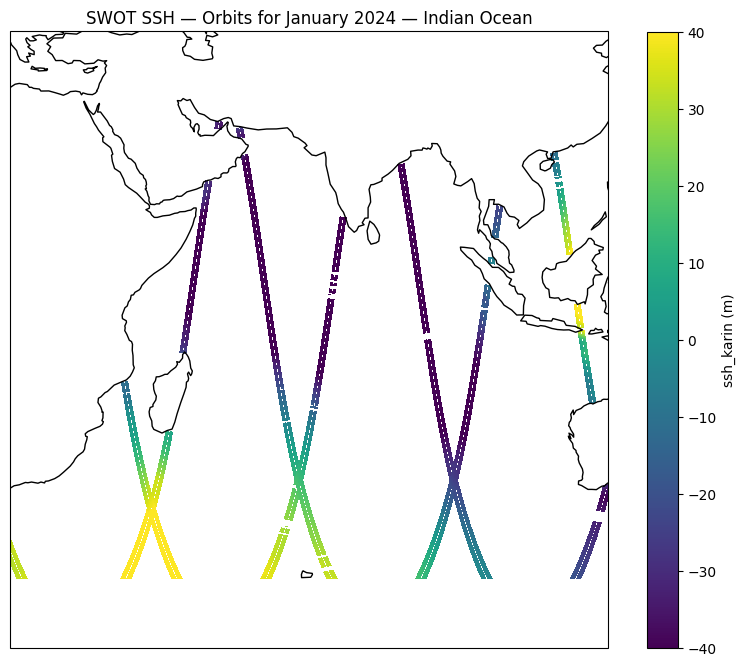

In [19]:
# Do the spatial plot
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([lon_min, lon_max, lat_min, lat_max])
ax.coastlines()

#for k in range(ssh_region.sizes["orbit"]):
for k in valid_orbits:
    ssh_i = ssh_region.isel(orbit=k).load()
    lat_i = lat.isel(orbit=k).load()
    lon_i = lon.isel(orbit=k).load()
    
    pcm = ax.pcolormesh(
        lon_i,
        lat_i,
        ssh_i,
        shading="auto",
        cmap="viridis",
        vmin=-40,
        vmax=40,
        transform=ccrs.PlateCarree()
    )

plt.colorbar(pcm, ax=ax, label="ssh_karin (m)")
plt.title("SWOT SSH — Orbits for January 2024 — Indian Ocean")
plt.show()
